In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [3]:
!pip install tabulate
!git clone https://github.com/ealeongomez/Data.git
!git clone https://github.com/ealeongomez/Predictive-Modeling-Using-a-Clustering-Based-Approach.git

Cloning into 'Data'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 46 (delta 10), reused 26 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 17.70 MiB | 9.39 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Cloning into 'Predictive-Modeling-Using-a-Clustering-Based-Approach'...
remote: Enumerating objects: 214, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 214 (delta 8), reused 16 (delta 6), pack-reused 196 (from 1)
Receiving objects: 100% (214/214), 283.25 MiB | 14.97 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Updating files: 100% (88/88), done.


In [4]:
# Basic packages
import pandas as pd
import os, pickle, re, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

# Machine learning packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Deep learning
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [5]:
os.chdir('/content/Predictive-Modeling-Using-a-Clustering-Based-Approach')

In [6]:
ls -l

total 3636
-rw-r--r-- 1 root root 1225140 Mar  4 14:39 Argone_IL.ipynb
-rw-r--r-- 1 root root 1212593 Mar  4 14:39 Beijing_Airport_China.ipynb
-rw-r--r-- 1 root root 1214371 Mar  4 14:39 Chengdu_Airport_China.ipynb
-rw-r--r-- 1 root root    1805 Mar  4 14:39 comparation.py
drwxr-xr-x 3 root root    4096 Mar  4 14:39 Experiments/
-rw-r--r-- 1 root root    2980 Mar  4 14:39 Final.py
drwxr-xr-x 2 root root    4096 Mar  4 14:39 Functions/
drwxr-xr-x 2 root root    4096 Mar  4 14:39 pkl/
-rw-r--r-- 1 root root    4868 Mar  4 14:39 plotter_individual.py
-rw-r--r-- 1 root root    4330 Mar  4 14:39 plotter.py
-rw-r--r-- 1 root root    1781 Mar  4 14:39 plot_TimeSeries.py
drwxr-xr-x 5 root root    4096 Mar  4 14:39 Proofs/
-rw-r--r-- 1 root root      56 Mar  4 14:39 README.md
-rw-r--r-- 1 root root     662 Mar  4 14:39 Resultados.eps
drwxr-xr-x 2 root root    4096 Mar  4 14:39 results/
drwxr-xr-x 3 root root    4096 Mar  4 14:39 stac/


In [7]:
from Experiments.NeuralNetworks import ForecastingModels
from Experiments.organizeData import selectSamples

# **Variables**

In [8]:
neurons = 9
layers = 1
epochs = 30
predictionHorizonMax = 7
batch_size = 512
dataSet = "Chengdu" # Beijing, Chengdu

In [9]:
data = {"City": ["Chengdu", "Beijing", "Argonne_IL"],
        "mse_RNN": [12, 12, 15], "mse_GRU": [11, 9, 7], "mse_LSTM": [11, 8, 8],
        "KernelMSE_RNN": [17, 9, 8], "KernelMSE_GRU": [20, 11, 12], "KernelMSE_LSTM": [20, 10, 13],
}

df_windows = pd.DataFrame(data)
df_windows.set_index("City", inplace=True)

display(df_windows)

,mse_RNN,mse_GRU,mse_LSTM,KernelMSE_RNN,KernelMSE_GRU,KernelMSE_LSTM
City,,,,,,
Chengdu,12,11,11,17,20,20
Beijing,12,9,8,9,11,10
Argonne_IL,15,7,8,8,12,13


# **Load data**

In [10]:
if dataSet == "Argonne_IL":
  df = pd.read_csv("/content/Data/WindSpeed/Argone_IL.txt", sep="\t", names=['yyyymmdd','hhmn','mph','code'])
  df = df[df["yyyymmdd"] >= 19980101]
  df["sped"] = pd.to_numeric(df["mph"], downcast="float")
  timeSerie = df.iloc[:,2].values
elif dataSet == "Beijing":
  df = pd.read_csv('/content/Data/WindSpeed/Beijing_Airport_China2.txt', delimiter=",")
  df["sped"] = pd.to_numeric(df["sped"], downcast="float")
  timeSerie = df.iloc[:,1].values
elif dataSet == "Chengdu":
  df = pd.read_csv("/content/Data/WindSpeed/Chengdu_Airport_China.txt", sep=",")
  df["sped"] = pd.to_numeric(df["sped "], downcast="float")
  timeSerie = df.iloc[:,2].values


valueMax = max(timeSerie)
print(max(timeSerie), min(timeSerie))

timeSerie = (timeSerie-min(timeSerie))/(valueMax-min(timeSerie))
samples = round(len(timeSerie)*0.80)

timeSerie_training = timeSerie[0:samples]
timeSerie_test     = timeSerie[samples:]
time = np.arange(0, len(timeSerie),1)


33.53 0.0


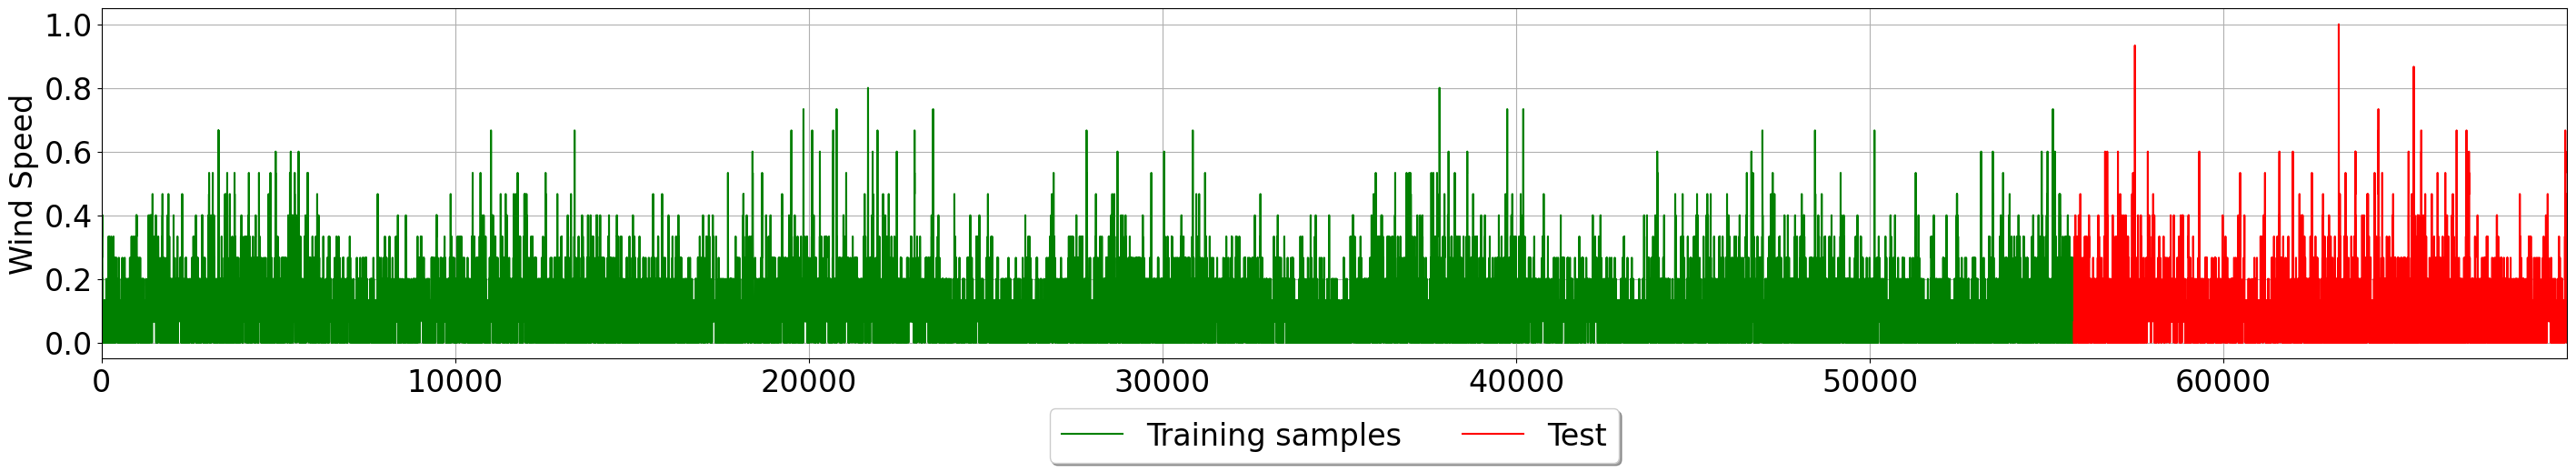

In [11]:
plt.figure(figsize=(35,5))
plt.plot(time[0:samples], timeSerie[0:samples], 'g', label= 'Training samples')
plt.plot(time[samples:], timeSerie[samples:], 'r', label= 'Test')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Wind Speed', fontsize=24)
plt.xlim(0, timeSerie.shape[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2, prop={'size': 24})
plt.grid(True)
plt.show()

# **Train models**

In [12]:
lossFunctions = df_windows.columns
results = {}

for loss in lossFunctions:
  # Variables
  function = re.findall("^([A-Za-z]+)", loss)[0]
  neuralNetwotk = re.findall("([A-Za-z]+)$", loss)[0]
  window = df_windows.loc[dataSet][loss]
  name = "{model}-{loss}".format(model=neuralNetwotk, loss=function)

  print("\n\t Model {model} and loss {loss} \n\t".format(model=neuralNetwotk, loss=function))

  # Organize dataset (train, valid, test)
  selectSamples_ = selectSamples(timeSerie_training, predictionHorizonMax, window)
  X_, y_ = selectSamples_.SerieMatriz()

  selectSamples_test = selectSamples(timeSerie_test, predictionHorizonMax, window)
  X_test, y_test = selectSamples_test.SerieMatriz()

  X_ = X_.reshape(X_.shape[0], X_.shape[1], 1)
  X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

  # Load model
  #model = ForecastingModels(X_, y_, X_test, y_test, neurons=neurons, batch_size=batch_size, epochs=1, loss_function=function, num_layers=1, n_splits=5)
  model = ForecastingModels(X_, y_, X_test, y_test, neurons=neurons, batch_size=512,
                              epochs=30, loss_function=function, num_layers=1, n_splits=5, use_cv=True)

  if neuralNetwotk == "RNN":
    test_scores, weights, all_history, all_pred, *e = model.RNNSimple_Model()
  elif neuralNetwotk == "GRU":
    test_scores, weights, all_history, all_pred, *e = model.GRU_Model()
  elif neuralNetwotk == "LSTM":
    test_scores, weights, all_history, all_pred, *e = model.GRU_Model()

  # Prepare the results for this iteration
  iteration_result = {
         "Cost Function": function,
         "Network": neuralNetwotk,
         "Window": window,
         "test_scores": test_scores,
         "history": all_history,
         "predictions": all_pred
    }

  results[name] = iteration_result



	 Model RNN and loss mse 
	
Fold 1
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Fold 2
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Fold 3
436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Fold 4
436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Fold 5
436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

	 Model GRU and loss mse 
	
Fold 1
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 2
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 3
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 4
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 5
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

	 Model LSTM and loss mse 
	
Fold 1
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 2
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 3
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Fold 4
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Fold 5
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step

	 Model RNN and loss KernelMSE 
	
Fold 1
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Fold 2
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Fold 3
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Fold 4
435/43

In [13]:
import pickle
with open("/content/drive/MyDrive/{}.pkl".format(dataSet), 'wb') as file:
    pickle.dump(results, file)